# NGC 6334I

Catalog at 220 AU:
https://ui.adsabs.harvard.edu/abs/2016ApJ...832..187B/abstract

In [1]:
from astropy import units as u
distance = 1.3*u.kpc # Chibueze+2014
field = 'NGC6334I'

In [2]:
cd /orange/adamginsburg/salt/sanhueza/NGC6334I/

/orange/adamginsburg/salt/sanhueza/NGC6334I


In [3]:
ls

cutout.reg
mm1_all.reg
mm1b.reg
mm1d.reg
mm2a.reg
NaCl_v_le_3_mm1b_stackcube.fits
NaCl_v_le_3_stackcube.fits
NGC6334I.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1.fits
NGC6334I.config8.spw0.robust0.5.image_small.fits
NGC6334I.config8.spw1.robust0.5.image_cb_smaller.fits
NGC6334I.config8.spw1.robust0.5.image_cb_smaller_mm1.fits
NGC6334I.config8.spw1.robust0.5.image_small.fits
NGC6334I.config8.spw2.robust0.5.image_cb_smaller.fits
NGC6334I.config8.spw2.robust0.5.image_cb_smaller_mm1.fits
NGC6334I.config8.spw2.robust0.5.image_small.fits
NGC6334I.config8.spw3.robust0.5.image_cb_smaller.fits
NGC6334I.config8.spw3.robust0.5.image_cb_smaller_mm1.fits
NGC6334I.config8.spw3.robust0.5.image_small.fits
NGC6334Imm1b_h2oPV_withcolorcurves.png
NGC6334Imm1b_m0m1_grid_ticks.png
NGC6334Imm1b_NaCl_mom0_ticks.png
NGC6334Imm1b_naclPV_withcolorcurves.png
NGC6334Imm1b_water_mom0_ticks.png
NGC63

In [4]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2af7d558f040>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import warnings
warnings.simplefilter('ignore')

In [9]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [10]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
regsm = regions.Regions.read('smallcutout.reg')
regmm2b = regions.Regions.read('mm2b.reg')
mm1b = regions.Regions.read('mm1b.reg')
mm1d = regions.Regions.read('mm1d.reg')
mm1_all = regions.Regions.read('mm1_all.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [77]:
mm1b

<Regions([<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (260.22256724, -35.78275207)>, width=0.4422 arcsec, height=0.2207 arcsec, angle=0.0 deg)>])>

In [78]:
regmm2b

<Regions([<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (260.221526, -35.783105)>, width=0.1971 arcsec, height=0.1356 arcsec, angle=323.61566 deg)>])>

In [81]:
mm1b[0].center.separation(regmm2b[0].center)

<Angle 0.00091546 deg>

In [82]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
cat = Vizier(row_limit=1e5).get_catalogs('J/A+A/635/A2')[0] #Sadaghiani 2020
sources = SkyCoord(cat['RAJ2000'], cat['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [83]:
# https://ui.adsabs.harvard.edu/abs/2016ApJ...832..187B/abstract

In [84]:
broganmasercat2 = Vizier(row_limit=1e5).get_catalogs('J/ApJ/866/87')[0] # Brogan 2018
ok = np.array([bool(x) for x in broganmasercat2['RAJ2000']], dtype='bool')
brogansources = SkyCoord(broganmasercat2['RAJ2000'][ok], broganmasercat2['DEJ2000'][ok], frame='fk5', unit=(u.h, u.deg))

In [85]:
brogancat3 = Vizier(row_limit=1e5).get_catalogs('J/ApJ/832/187/table2')[0] # Brogan 2016
ok = np.array([bool(x) for x in brogancat3['RAJ2000']], dtype='bool')
broganmmsources = SkyCoord(brogancat3['RAJ2000'][ok], brogancat3['DEJ2000'][ok], frame='fk5', unit=(u.h, u.deg))

(-1.0, 182.0, -1.0, 177.0)

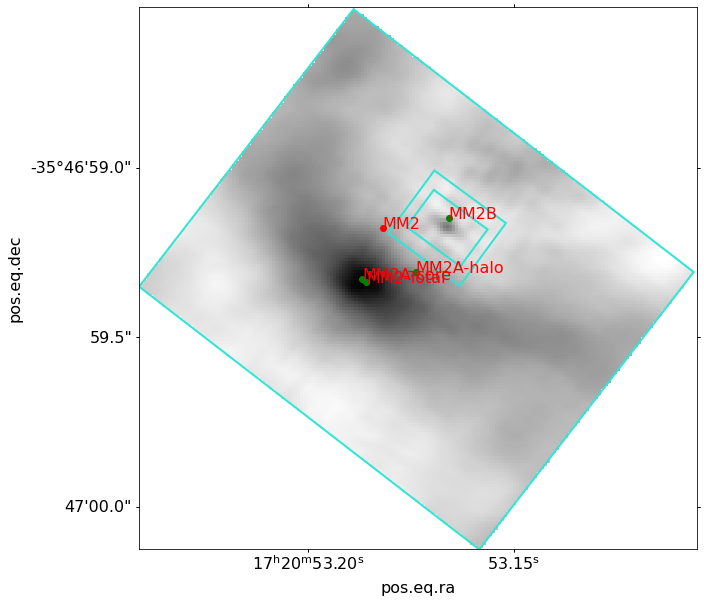

In [86]:
cont = SpectralCube.read('NGC6334I.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits').subcube_from_regions(reg)
pl.figure(figsize=(10,10))

ww=cont[0].wcs
ww._naxis = cont[0].shape

ax = pl.subplot(projection=ww)
ax.imshow(cont[0].value, cmap='gray_r')
reg[0].to_pixel(ww).plot(ax=ax)
regsm[0].to_pixel(ww).plot(ax=ax)
regmm2b[0].to_pixel(ww).plot(ax=ax)
#ax.axis([3100,3500,1850,2250])
ax.scatter(sources.ra.deg, sources.dec.deg, c='r', transform=ax.get_transform('fk5'))
for row,src,ok in zip(cat, sources, ww.footprint_contains(sources)):
    if ok:
        txt = row['ONames'] or row['Seq']
        #print(row['ONames'], row['Seq'])
        xx,yy = cont[0].wcs.world_to_pixel(src)
        ax.annotate(str(txt), (xx,yy), color='r')
ax.scatter(broganmmsources.ra.deg, broganmmsources.dec.deg, c='green', transform=ax.get_transform('fk5'))
for row,src,ok in zip(brogancat3, broganmmsources, ww.footprint_contains(broganmmsources)):
    if ok:
        txt = row['Name'] + row['m_Name']
        #print(row['ONames'], row['Seq'])
        xx,yy = cont[0].wcs.world_to_pixel(src)
        ax.annotate(str(txt), (xx,yy), color='r')
    #ax.annotate(str(txt), (src.ra.deg, src.dec.deg), transform=ax.get_transform('fk5'), color='r')
    #ax.text(src.ra.deg, src.dec.deg, txt, transform=ax.get_transform('fk5'), color='r')
pp = reg[0].to_pixel(ww)
bb = pp.bounding_box
ax.axis([bb.ixmin, bb.ixmax, bb.iymin, bb.iymax])

(0.0, 277.0, -1.0, 310.0)

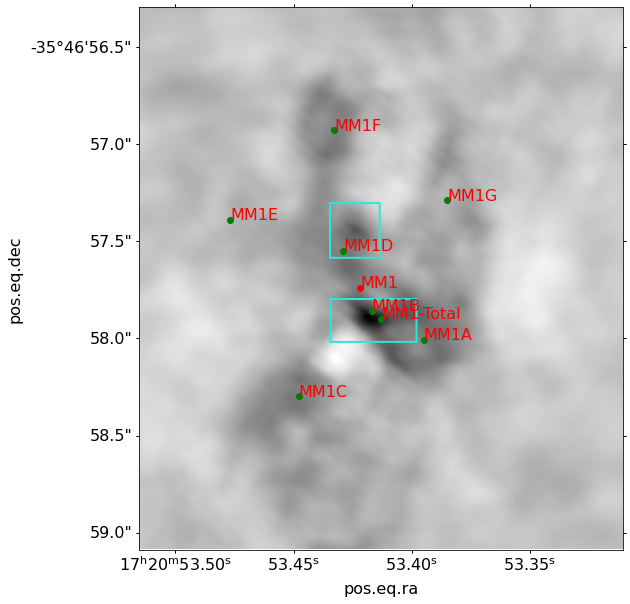

In [87]:
cont = SpectralCube.read('NGC6334I.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits').subcube_from_regions(mm1_all)
pl.figure(figsize=(10,10))

ww=cont[0].wcs
ww._naxis = cont[0].shape

ax = pl.subplot(projection=ww)
ax.imshow(cont[0].value, cmap='gray_r')
reg[0].to_pixel(ww).plot(ax=ax)
mm1b[0].to_pixel(ww).plot(ax=ax)
mm1d[0].to_pixel(ww).plot(ax=ax)
#ax.axis([3100,3500,1850,2250])
ax.scatter(sources.ra.deg, sources.dec.deg, c='r', transform=ax.get_transform('fk5'))
for row,src,ok in zip(cat, sources, ww.footprint_contains(sources)):
    if ok:
        txt = row['ONames'] or row['Seq']
        #print(row['ONames'], row['Seq'])
        xx,yy = cont[0].wcs.world_to_pixel(src)
        ax.annotate(str(txt), (xx,yy), color='r')
ax.scatter(broganmmsources.ra.deg, broganmmsources.dec.deg, c='green', transform=ax.get_transform('fk5'))
for row,src,ok in zip(brogancat3, broganmmsources, ww.footprint_contains(broganmmsources)):
    if ok:
        txt = row['Name'] + row['m_Name']
        #print(row['ONames'], row['Seq'])
        xx,yy = cont[0].wcs.world_to_pixel(src)
        ax.annotate(str(txt), (xx,yy), color='r')
    #ax.annotate(str(txt), (src.ra.deg, src.dec.deg), transform=ax.get_transform('fk5'), color='r')
    #ax.text(src.ra.deg, src.dec.deg, txt, transform=ax.get_transform('fk5'), color='r')
pp = mm1_all[0].to_pixel(ww)
bb = pp.bounding_box
ax.axis([bb.ixmin, bb.ixmax, bb.iymin, bb.iymax])

# NaCl Stackl

In [88]:
from spectral_cube.analysis_utilities import stack_cube

In [89]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [90]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [91]:
flist = (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_small.fits'))

In [92]:
for fn in flist:
    outfile = fn.replace("_small","_cb_smaller")
    if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
        cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg)
        cube.allow_huge_operations=True
        cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
        scube = cube.to(u.K).convolve_to(cb)
        scube.allow_huge_operations = True
        scube.write(outfile, overwrite=True)

In [93]:
cubes = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg) for fn in (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_cb_smaller.fits'))]

cubes

[DaskSpectralCube with shape=(3840, 176, 181) and unit=K and chunk size (480, 176, 181):
  n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
  n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.783366 deg:  -35.782928 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562733015.300 Hz:235437322762.241 Hz,
 DaskSpectralCube with shape=(3840, 176, 181) and unit=K and chunk size (480, 176, 181):
  n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
  n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.783366 deg:  -35.782928 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062731290.525 Hz:220937321037.700 Hz,
 DaskSpectralCube with shape=(3840, 176, 181) and unit=K and chunk size (480, 176, 181):
  n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
  n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.783366 deg:  -35.782928 deg
  n_s: 

In [94]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [95]:
cb

Beam: BMAJ=0.08507879235014157 arcsec BMIN=0.051829406640658236 arcsec BPA=68.469145550765 deg

In [96]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 110.60243006 AU>

In [97]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 67.37822863 AU>

In [98]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [99]:
from astropy import log
log.setLevel('INFO')

In [100]:
#log.setLevel('DEBUG')
vcen = -5 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [101]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits').to(u.K)
stackc

SpectralCube with shape=(91, 176, 181) and unit=K:
 n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
 n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.783366 deg:  -35.782928 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -35.227 km / s:      25.214 km / s

stackc = stackc.subcube_from_regions(regmm2b)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 20*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (stackc > 20*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()

m1 = stackc.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


#vmap = m1.hdu

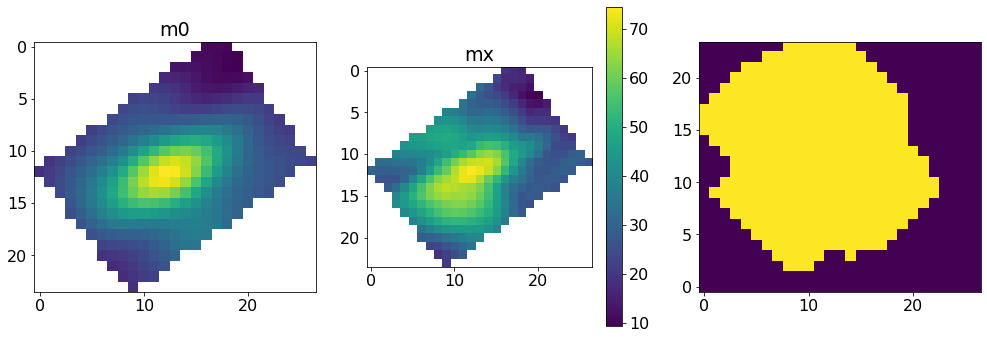

<Figure size 432x288 with 0 Axes>

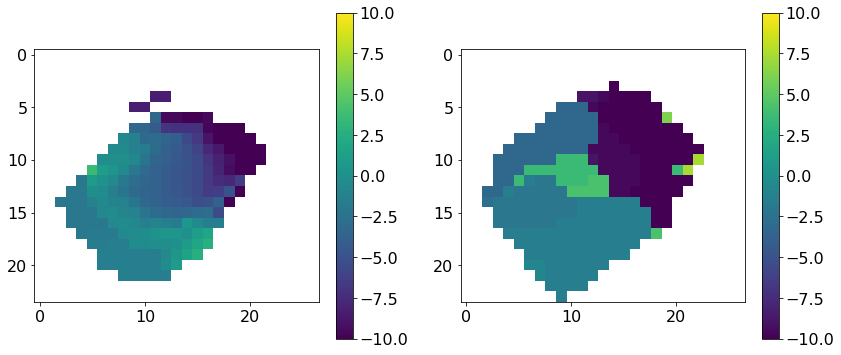

In [102]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube.subcube_from_regions(regmm2b).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 40*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (scube > 30*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


vmap = m1.hdu
#vmap = mxv.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

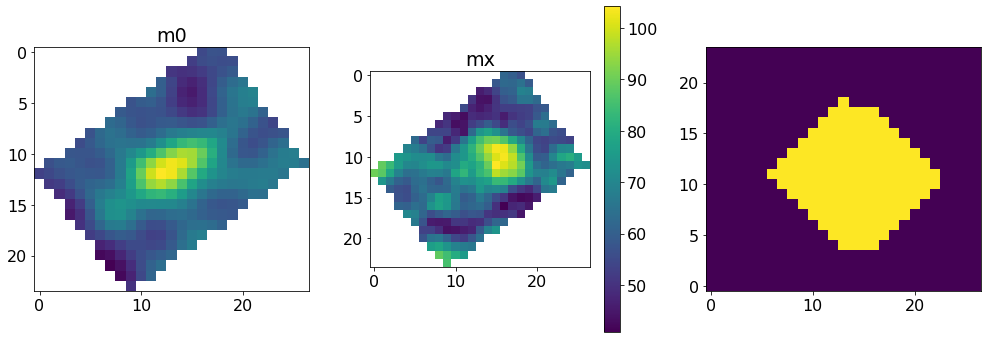

<Figure size 432x288 with 0 Axes>

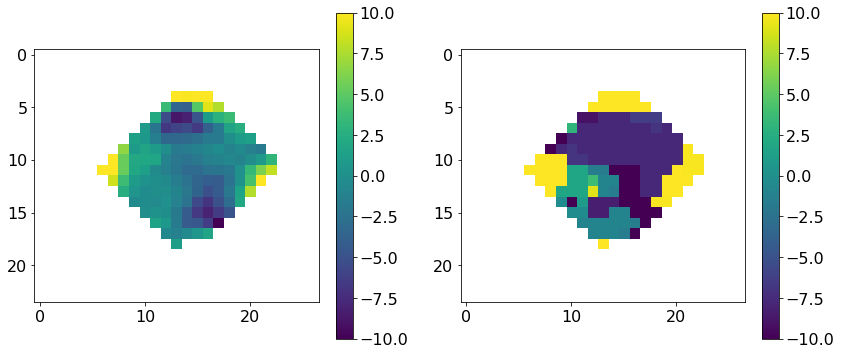

In [103]:
# try creating a vmap based on another line
restval = 217.817644*u.GHz # SiS
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube.subcube_from_regions(regmm2b).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 65*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=2)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (scube > 35*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


#vmap = m1.hdu
#vmap = mxv.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [104]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [105]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regmm2b).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'NGC6334I mm2b spw{ii}'

In [106]:
mkdir -p spectra/figures

NGC6334I_mm2b_spw0
NGC6334I_mm2b_spw1
NGC6334I_mm2b_spw2
NGC6334I_mm2b_spw3


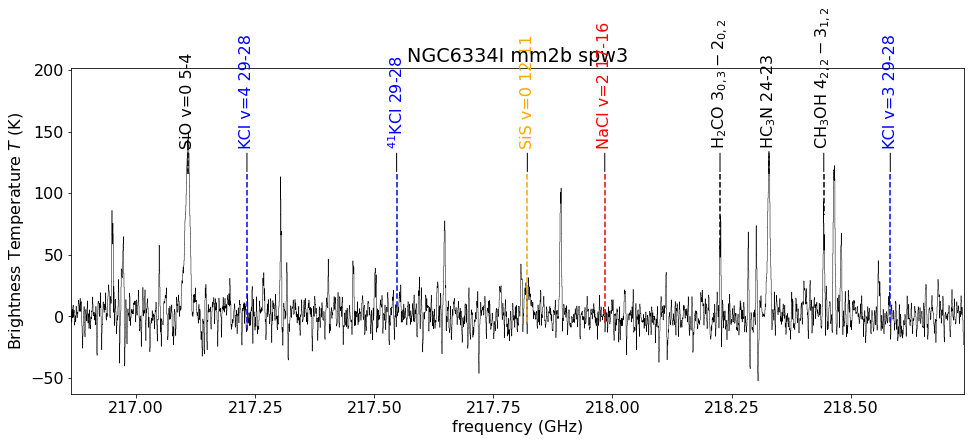

In [107]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [108]:
ls spectra/figures/color_labels_NGC6334I_mm2b*

spectra/figures/color_labels_NGC6334I_mm2b_spw0.png
spectra/figures/color_labels_NGC6334I_mm2b_spw0_stack.png
spectra/figures/color_labels_NGC6334I_mm2b_spw1.png
spectra/figures/color_labels_NGC6334I_mm2b_spw1_stack.png
spectra/figures/color_labels_NGC6334I_mm2b_spw2.png
spectra/figures/color_labels_NGC6334I_mm2b_spw2_stack.png
spectra/figures/color_labels_NGC6334I_mm2b_spw3.png
spectra/figures/color_labels_NGC6334I_mm2b_spw3_stack.png


In [109]:
from IPython.display import Image,display

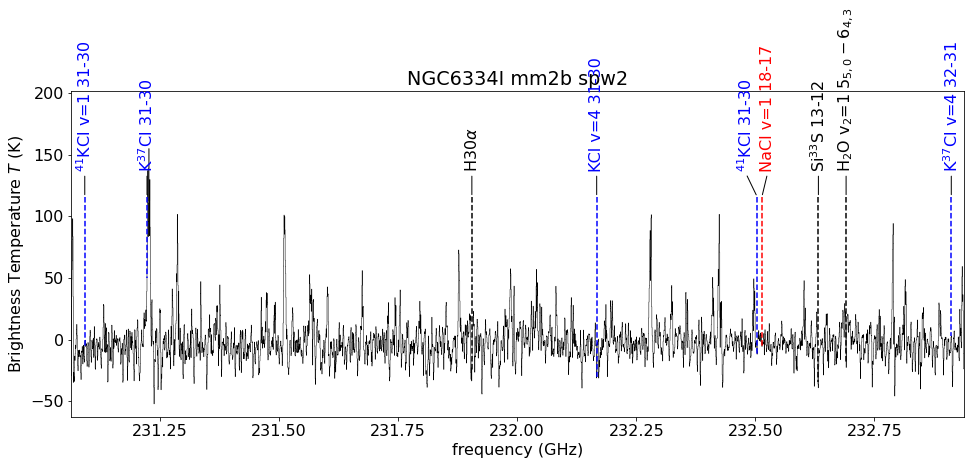

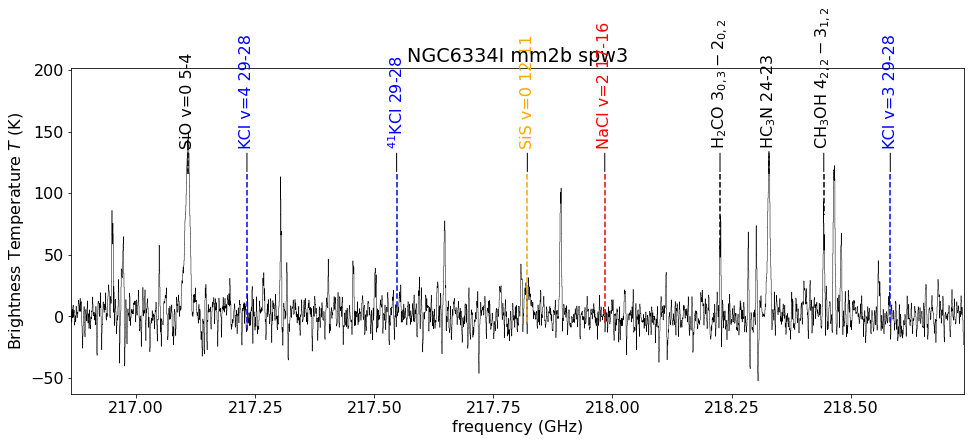

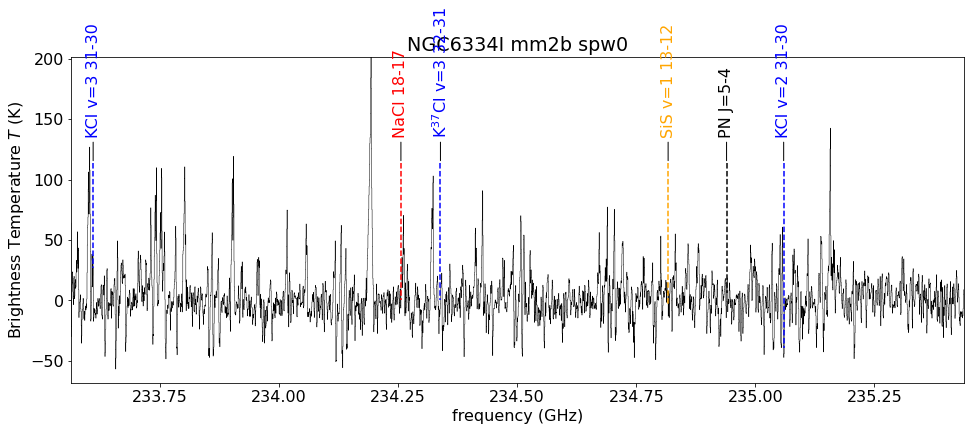

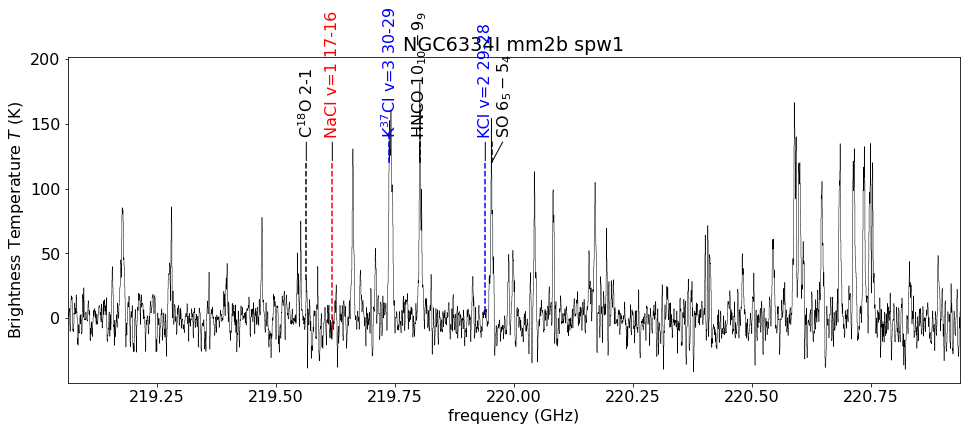

In [110]:
for fn in glob.glob('spectra/figures/color_labels_NGC6334I_mm2b_spw[0-3].png'):
    display(Image(fn))

DaskSpectralCube with shape=(3840, 176, 181) and unit=K and chunk size (480, 176, 181):
 n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
 n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.783366 deg:  -35.782928 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562733015.300 Hz:235437322762.241 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 176, 181) and unit=K and chunk size (480, 176, 181):
 n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
 n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.783366 deg:  -35.782928 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062731290.525 Hz:220937321037.700 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 176, 181) and unit=K and chunk size (480, 176, 181):
 n_x:    181  type_x: RA---SIN  unit_x: deg    range:   260.221279 deg:  260.221834 deg
 n_y:    176  type_y: DEC--SIN  unit_y: deg    range:   -35.78

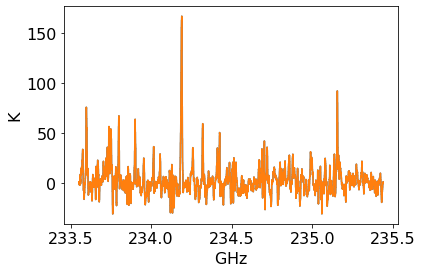

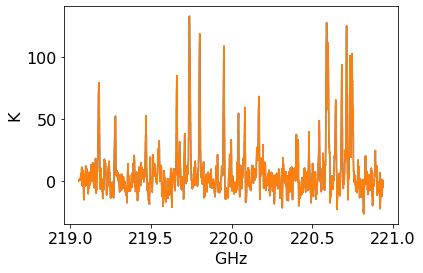

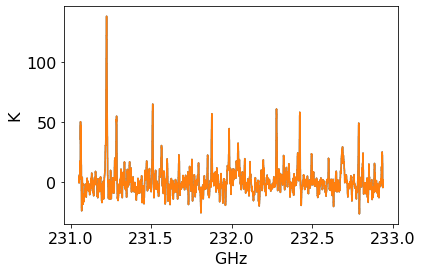

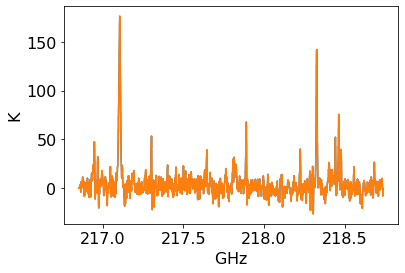

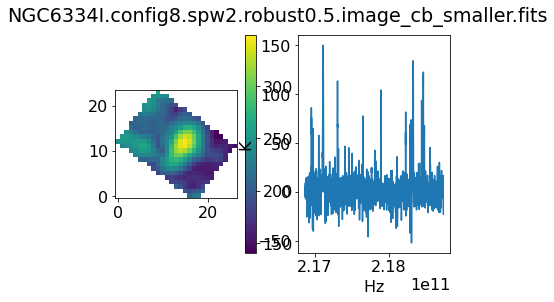

In [111]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy.io import fits

cbflist = (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_cb_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regmm2b)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_NGC6334Imm2b_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap_mm2b.fits', overwrite=True)    
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_NGC6334Imm2b_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_mm2b_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_mm2b_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [112]:
ls spectra

figures/
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_meanspec.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_mm1b_meanspec.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_mm1b_stack.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_mm1d_meanspec.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_mm1d_stack.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_NGC6334Imm1b_meanspec.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_NGC6334Imm1b_stack.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_NGC6334Imm1d_meanspec.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm1_NGC6334Imm1d_stack.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_mm2b_stack.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_NGC6334Imm2b_meanspec.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_NGC6334Imm2b_stack.fits
NGC6334I.config8.spw0.robust0.5.image_cb_smaller_stack.fits
NGC6334I.config8.spw1.robust0.5.image_cb_smaller_meanspec.

In [113]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*smaller_mm2b_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]} mm2b {spl[2]} stack'
    stackspectra.append(pysp)

NGC6334I_mm2b_spw2_stack
NGC6334I_mm2b_spw0_stack
NGC6334I_mm2b_spw3_stack
NGC6334I_mm2b_spw1_stack


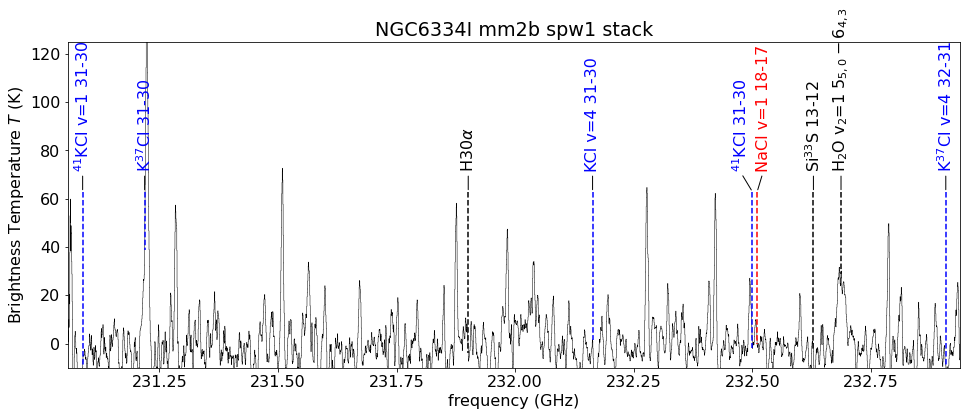

In [114]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymax=125, ymin=-10, yfrac=0.6)

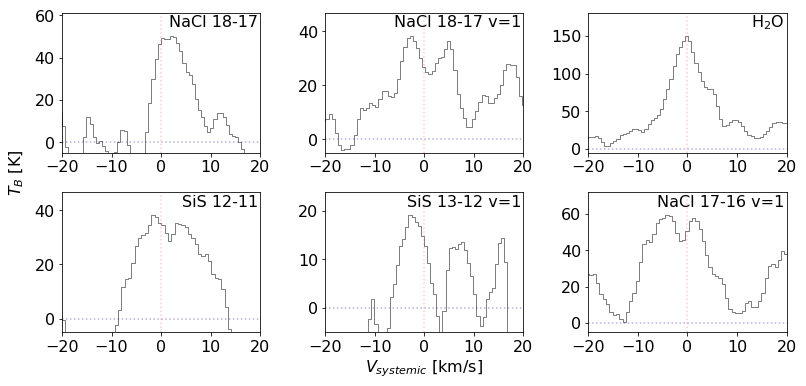

In [115]:
def line_zooms(globstr, linelist, gridshape=(3,3), vcen=vcen, dv=10*u.km/u.s, ymin=None, ymax=None):

    spectra = [pyspeckit.Spectrum(fn) for fn in glob.glob(globstr)]
    
    fig = pl.gcf()
    
    ax0 = fig.add_subplot(111, frameon=False)
    ax0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax0.set_ylabel("$T_B$ [K]")
    ax0.set_xlabel("$V_{systemic}$ [km/s]")

    plotnum = 1
    for linename, linefreq in linelist.items():
        for sp in spectra:
            if sp.xarr.in_range(linefreq):
                ax = fig.add_subplot(*gridshape, plotnum)
                sp.xarr.convert_to_unit(u.km/u.s, refX=linefreq)
                sp.plotter(axis=ax, xmin=vcen-dv, xmax=vcen+dv, ymin=ymin, ymax=ymax)
                ax.text(0.99, 0.9, linename, transform=ax.transAxes, ha='right')
                ax.axvline(vcen.value, color='r', linestyle=':', alpha=0.2)
                ax.axhline(0, color='navy', linestyle=':', zorder=-5, alpha=0.3)
                ax.set_xlabel("")
                ax.set_ylabel("")
                sp.xarr.convert_to_unit(u.GHz)
                plotnum += 1
    pl.tight_layout()

pl.figure(figsize=(12,6))
line_zooms('spectra/*_mm1b_stack.fits', {'NaCl 18-17':  234.251912*u.GHz,
                                         'NaCl 18-17 v=1': 232.509977*u.GHz,
                                         'H$_2$O':  232.6867*u.GHz,
                                         'SiS 12-11':  217.817644*u.GHz,
                                         'SiS 13-12 v=1': 234.8129678*u.GHz,
                                         'NaCl 17-16 v=1': 219.614936*u.GHz,}, gridshape=(2,3),
           vcen=0*u.km/u.s,
           dv=20*u.km/u.s,
           ymin=-5)

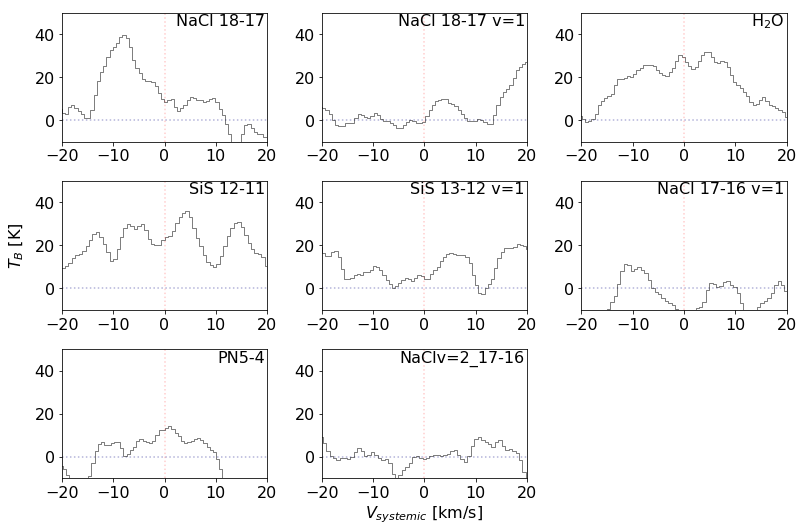

In [116]:
pl.figure(figsize=(12,8))
line_zooms('spectra/*smaller_stack.fits', {'NaCl 18-17':  234.251912*u.GHz,
                                         'NaCl 18-17 v=1': 232.509977*u.GHz,
                                         'H$_2$O':  232.6867*u.GHz,
                                         'SiS 12-11':  217.817644*u.GHz,
                                         'SiS 13-12 v=1': 234.8129678*u.GHz,
                                         'NaCl 17-16 v=1': 219.614936*u.GHz,
                                         'PN5-4': 234.935663*u.GHz,
                                         'SiSv=0_13-12': 235.9613634*u.GHz,
                                         'NaClv=2_17-16': 217.979967*u.GHz, # NaCl v=2 17-16
                                         'NaClv=2_18-17':230.7791504*u.GHz, # NaCl v=2 18-17 Unknown_2
                                        }, gridshape=(3,3),
           vcen=0*u.km/u.s,
           dv=20*u.km/u.s,
           ymin=-10,
           ymax=50)

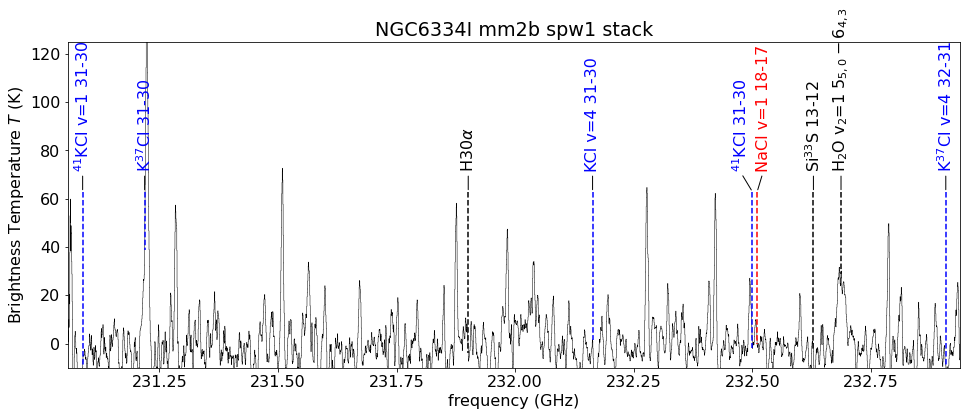

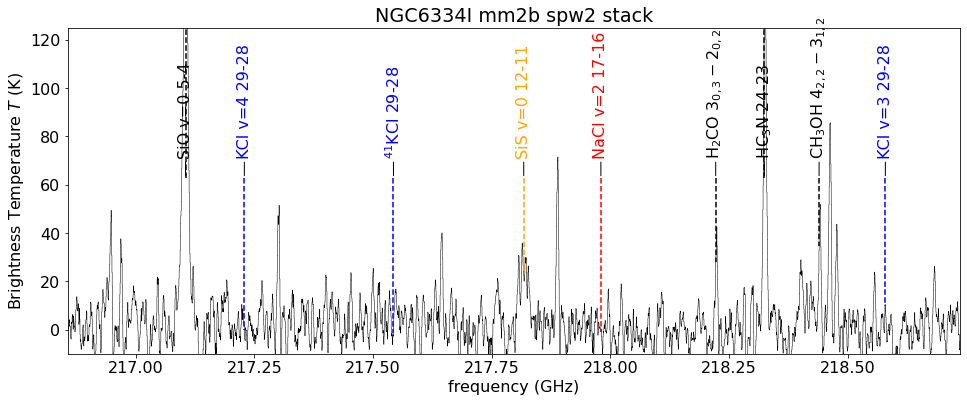

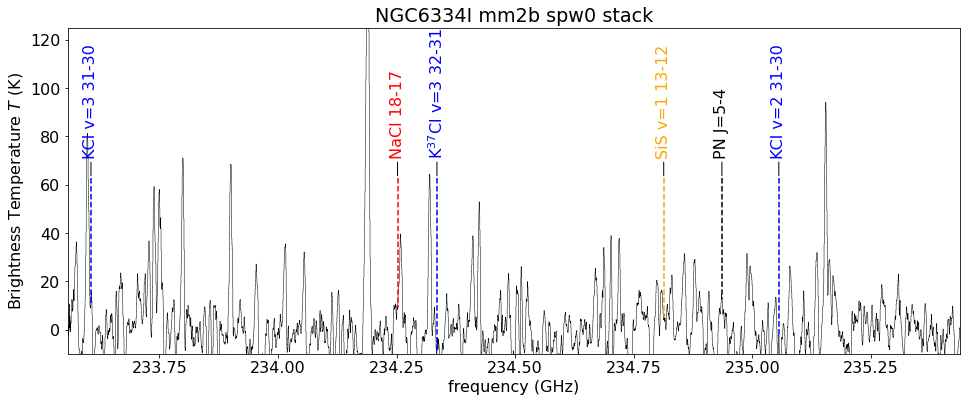

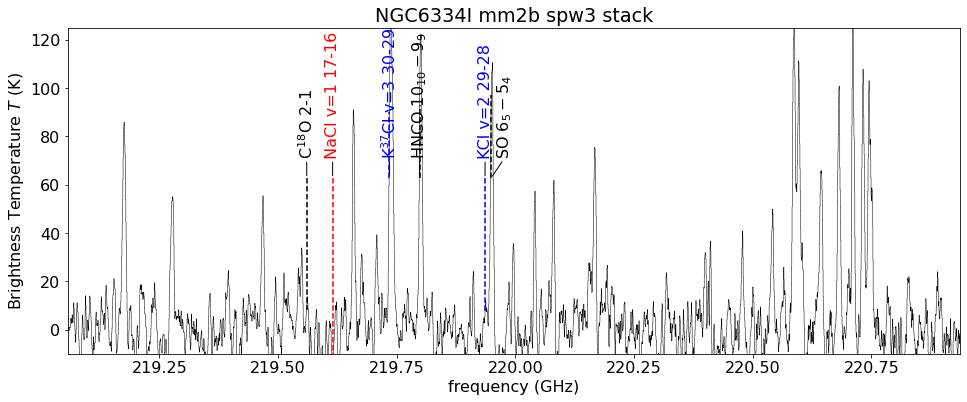

In [117]:
for fn in glob.glob('spectra/figures/color_labels_NGC6334I_mm2b_spw[0123]_stack.png'):
    display(Image(fn))

In [118]:
pixscale_au = (np.abs((wcs.utils.proj_plane_pixel_area(stackc.wcs.celestial)**0.5*u.deg).to(u.arcsec)) * distance).to(u.au, u.dimensionless_angles())
pixscale_au

<Quantity 11.7 AU>

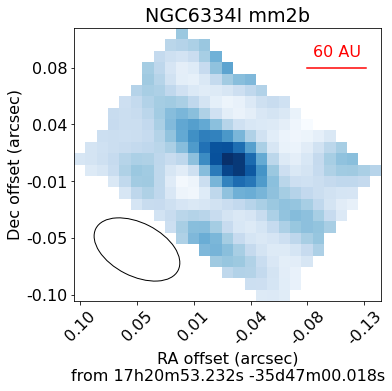

In [119]:
m0 = stackc.subcube_from_regions(regmm2b).moment0()

pl.figure(figsize=(5.5,5.5))
pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

dp_60 = (60*u.au / pixscale_au).decompose()

pl.title("NGC6334I mm2b")
pl.plot([20, 20+dp_60], [20,20], color='r')
pl.text(20 + dp_60/2, 21, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xc,yc = 11,11
xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xc-xtlocs)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-yc)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)


offset_loc = stackc.wcs.celestial.pixel_to_world(xc,yc)

ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("NGC6334Imm2b_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

TODO: make this work for mm2b


m0 = watermm1cubemm1cube.moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

dp_60 = (60*u.au / pixscale_au).decompose()

pl.title("NGC6334I mm1b")
pl.plot([20, 20+dp_60], [20,20], color='r')
pl.text(20 + dp_60/2, 21, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(watermm1cube.wcs.celestial)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xtlocs-10)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-10)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)


ax.set_xlabel("RA offset (arcsec)")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("NGC6334Imm1b_water_mom0_ticks.png", bbox_inches='tight', dpi=300)

In [120]:
vcen

<Quantity -5. km / s>

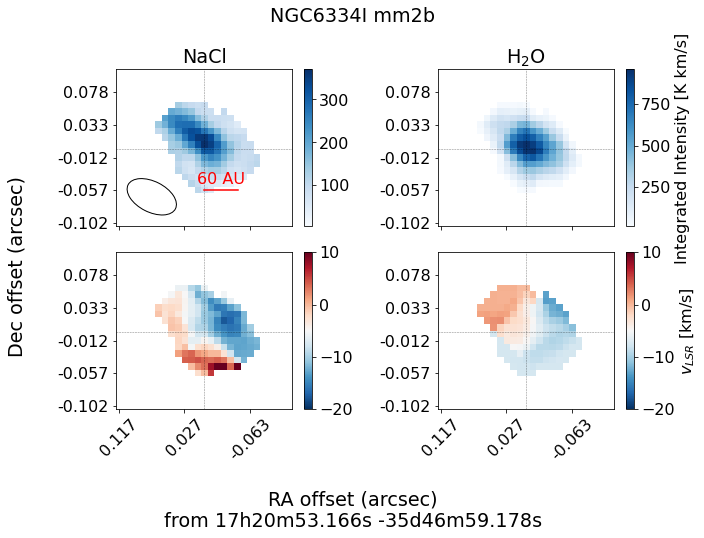

In [121]:
cube = SpectralCube.read('NGC6334I.config8.spw2.robust0.5.image_cb_smaller.fits')

h2ocubemm2b = watercubemm2b = scubemm2b = (cube.subcube_from_regions(regmm2b)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-15*u.km/u.s+vcen, 15*u.km/u.s+vcen))

assert h2ocubemm2b.shape[0] > 1
      
      
# note for no reason   
m3dw = (watercubemm2b.subcube_from_regions(regmm2b) > 35*u.K).include()
m3dw = scipy.ndimage.binary_erosion(m3dw, iterations=2)
m3dw = scipy.ndimage.binary_dilation(m3dw, iterations=3)
#m3dw = m3dw.compute()
m0h2o = watercubemm2b.subcube_from_regions(regmm2b).with_mask(m3dw).moment0(axis=0)
m1h2o = watercubemm2b.subcube_from_regions(regmm2b).with_mask(m3dw).moment1(axis=0)



m3d = (stackc.subcube_from_regions(regmm2b) > 5*u.K).include()
m3d = scipy.ndimage.binary_erosion(m3d, iterations=2)
m3d = scipy.ndimage.binary_dilation(m3d, iterations=3)
#m3d = m3d.compute()

m3d &= m3dw.any(axis=0)


# this shouldn't be needed but just to be safe...
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits').to(u.K)
m0 = stackc.subcube_from_regions(regmm2b).with_mask(m3d).moment0()
m1 = stackc.subcube_from_regions(regmm2b).with_mask(m3d).moment1()

      

fig = pl.figure(figsize=(10,7.5))
ax1 = pl.subplot(2,2,1, )#projection=m0.wcs)
im1 = ax1.imshow(m0.value, cmap='Blues', origin='lower')
ax1.set_title("NaCl")
pl.colorbar(mappable=im1)

vmin = vcen.value-15
vmax = vcen.value+15

ax2 = pl.subplot(2,2,2, )#projection=m0h2omm1.wcs)
im2 = ax2.imshow(m0h2o.value, cmap='Blues', origin='lower',)
ax2.set_title("H$_2$O")
cb2 = pl.colorbar(mappable=im2)
cb2.set_label("Integrated Intensity [K km/s]")

ax3 = pl.subplot(2,2,3, )#projection=m1.wcs)
im3 = ax3.imshow(m1.value, cmap='RdBu_r', origin='lower',  vmin=vmin, vmax=vmax)
pl.colorbar(mappable=im3)


ax4 = pl.subplot(2,2,4, )#projection=m1h2omm1.wcs)
im4 = ax4.imshow(m1h2o.value, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
cb4 = pl.colorbar(mappable=im4)
cb4.set_label("$v_{LSR}$ [km/s]")

dp_60 = (60*u.au / pixscale_au).decompose()
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))

axlims = ax1.axis()

#xc,yc = 28,29
#offset_loc = m0.wcs.celestial.pixel_to_world(xc,yc)
offset_loc = regmm2b[0].center
xc,yc = m0.wcs.celestial.world_to_pixel(offset_loc)


for ax_ in (ax1,ax2,ax3,ax4):

    xtlocs = ax_.get_xticks()
    xticklabels = map(lambda x: f"{x:0.3f}", (xc-xtlocs)*pixscale.value)
    ax_.set_xticks(xtlocs, xticklabels, rotation=45)
    ax_.axhline(yc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    ax_.axvline(xc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    ytlocs = ax1.get_yticks()
    yticklabels = map(lambda x: f"{x:0.3f}", (ytlocs-yc)*pixscale.value)
    ax_.set_yticks(ytlocs, yticklabels, rotation=0)

    ax_.axis(axlims)
    
for ax_ in (ax1,ax2):
    ax_.set_xticklabels([])


pl.suptitle("NGC6334I mm2b")
blx = xc
bly = 5
ax1.plot([blx, blx+dp_60], [bly,bly], color='r')
ax1.text(blx + dp_60/2, bly+1, f'60 AU', horizontalalignment='center', color='r')

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
ax1.add_artist(bmell)


#ax = fig.add_subplot(111,frameon=False)
#pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}", labelpad=30)
#ax.set_ylabel("Dec offset (arcsec)", labelpad=15)

fig.supxlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}",)
fig.supylabel("Dec offset (arcsec)",)


pl.tight_layout()
pl.savefig("NGC6334Imm2b_m0m1_grid_ticks.png", bbox_inches='tight', dpi=300)
#
#contrep,_ = reproject.reproject_interp(cont[0].hdu, m0.header)
#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.contour(contrep,
#                levels=[0.01, 0.02, 0.03, 0.04], colors=['k']*5, linewidths=[0.5]*5)
#pl.savefig("G17_m0m1_grid_ticks_withcont.png", bbox_inches='tight', dpi=300)

## Note Sep 22, 2022

What the heck - is water counter-rotating with NaCl?


The outflow axis is totally unclear.

# NGC 6334I MM1b

In [122]:
flist = (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_small.fits'))

In [123]:
for fn in flist:
    outfile = fn.replace("_small","_cb_smaller_mm1")
    if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
        cube_ = SpectralCube.read(fn, use_dask=True).subcube_from_regions(mm1_all)
        cube_.allow_huge_operations=True
        cb = cube_.beams.common_beam(max_iter=20, max_epsilon=0.01)
        scube = cube_.to(u.K).convolve_to(cb)
        scube.allow_huge_operations = True
        scube.write(outfile, overwrite=True)

In [124]:
cubesmm1 = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(mm1_all)
         for fn in (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_cb_smaller_mm1.fits'))]
cubesmm1

[DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
  n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
  n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562733015.300 Hz:235437322762.241 Hz,
 DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
  n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
  n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062732718.000 Hz:232937322464.941 Hz,
 DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
  n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
  n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
  n_s: 

In [125]:
#log.setLevel('DEBUG')
vcen = -5 * u.km/u.s # from Patricio
stackcmm1b, cutouts = stack_cube(cubesmm1,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stackcmm1b.write('NaCl_v_le_3_mm1b_stackcube.fits', overwrite=True)

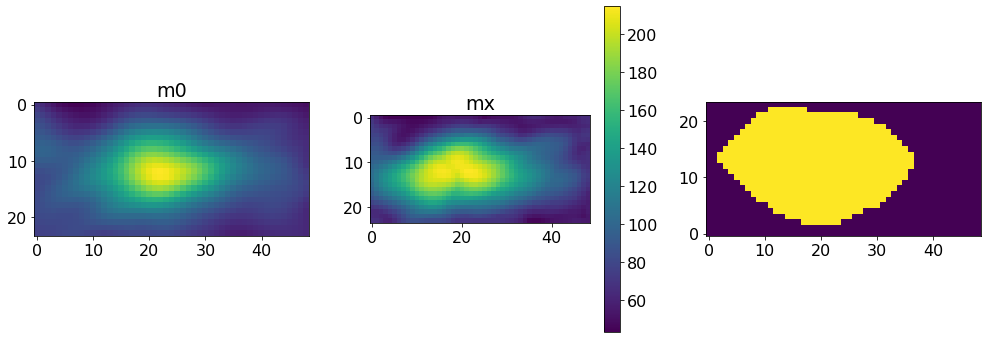

<Figure size 432x288 with 0 Axes>

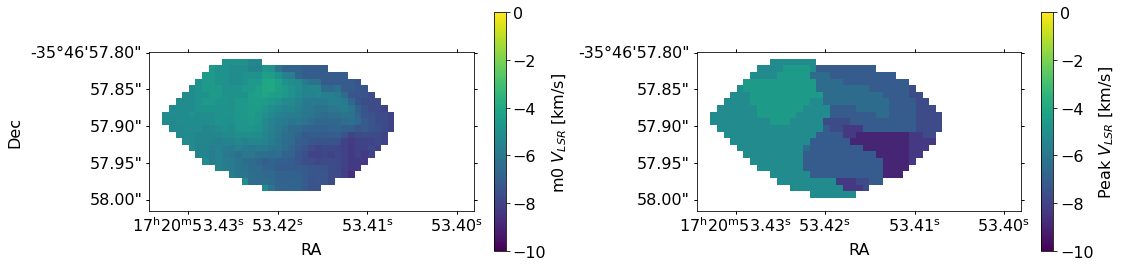

In [126]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube_ = [c for c in cubesmm1 if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube_.subcube_from_regions(mm1b).to(u.K).with_spectral_unit(u.km/u.s, velocity_convention='radio',
                                                           rest_value=restval).spectral_slab(vcen-30*u.km/u.s, vcen+30*u.km/u.s)
watermm1cube = scube
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 145*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (scube > 100*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,4))
ax1 = pl.subplot(1,2,1, projection=m1.wcs)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
clb = pl.colorbar(mappable=im)
clb.set_label('m0 $V_{LSR}$ [km/s]')
ax1.coords['dec'].set_axislabel('Dec')
ax1.coords['ra'].set_axislabel('RA')

mxv = scube.with_mask(msk).argmax_world(axis=0)
ax2 = pl.subplot(1,2,2, projection=m1.wcs)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
clb = pl.colorbar()
clb.set_label('Peak $V_{LSR}$ [km/s]')
pl.tight_layout()
ax2.coords['dec'].set_axislabel(' ')
ax2.coords['ra'].set_axislabel('RA')

pl.subplots_adjust(wspace=0.35)

vmap_mm1b = m1.hdu

DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
 n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
 n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562733015.300 Hz:235437322762.241 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
 n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
 n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062732718.000 Hz:232937322464.941 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
 n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
 n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.78

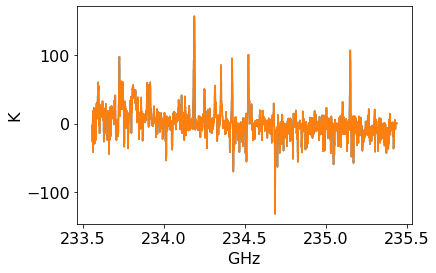

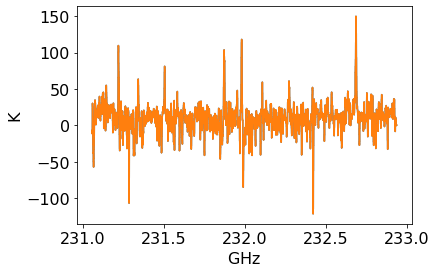

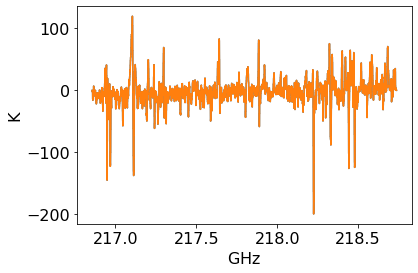

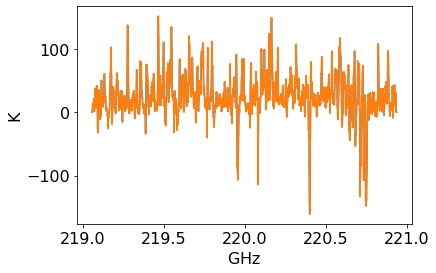

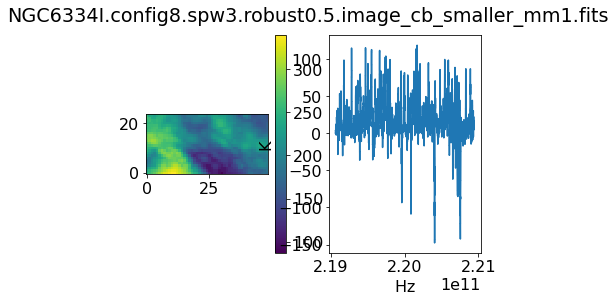

In [127]:
cbflist = (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_cb_smaller_mm1.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(mm1b).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_NGC6334Imm1b_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap_mm1b,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap_mm1b.fits', overwrite=True)    
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_NGC6334Imm1b_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_mm1b_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_mm1b_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [128]:
stackspectramm1b = []
for ii,fn in enumerate(glob.glob('spectra/*_mm1b_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]} {spl[2]} mm1b stack'
    stackspectramm1b.append(pysp)

NGC6334I_spw2_mm1b_stack
NGC6334I_spw0_mm1b_stack
NGC6334I_spw3_mm1b_stack
NGC6334I_spw1_mm1b_stack


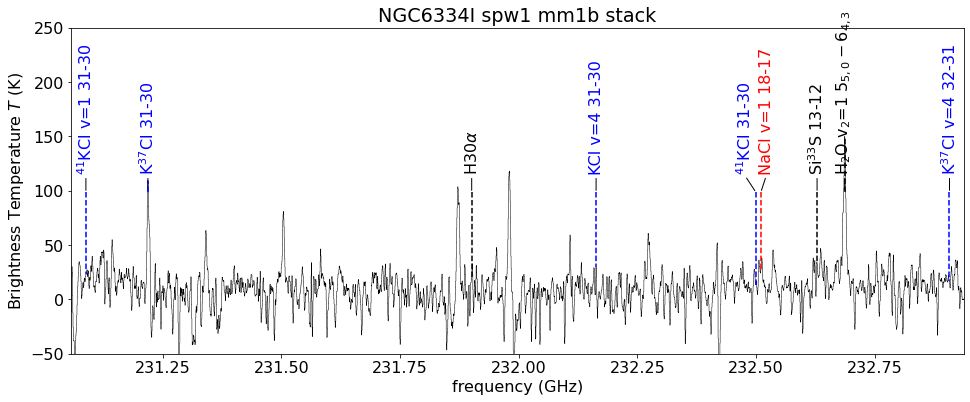

In [129]:
overplot_saltlines(stackspectramm1b, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-50, ymax=250, yfrac=0.55)

In [130]:
ls spectra/figures/color*mm1b_stack.png

spectra/figures/color_labels_NGC6334I_spw0_mm1b_stack.png
spectra/figures/color_labels_NGC6334I_spw1_mm1b_stack.png
spectra/figures/color_labels_NGC6334I_spw2_mm1b_stack.png
spectra/figures/color_labels_NGC6334I_spw3_mm1b_stack.png


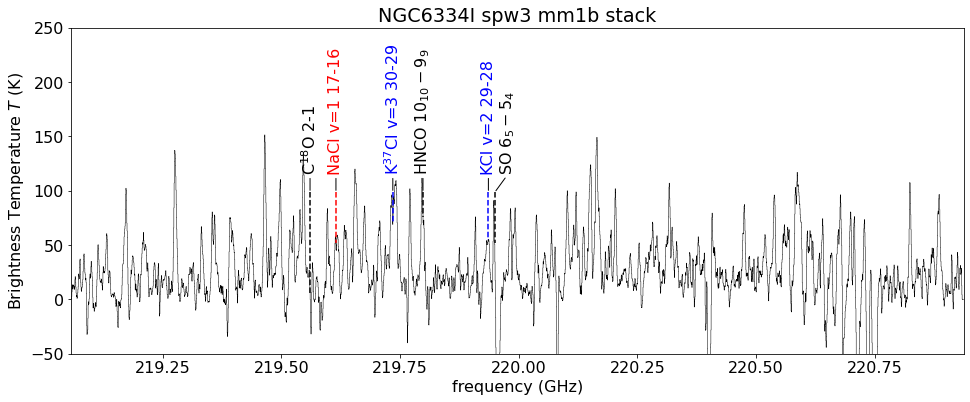

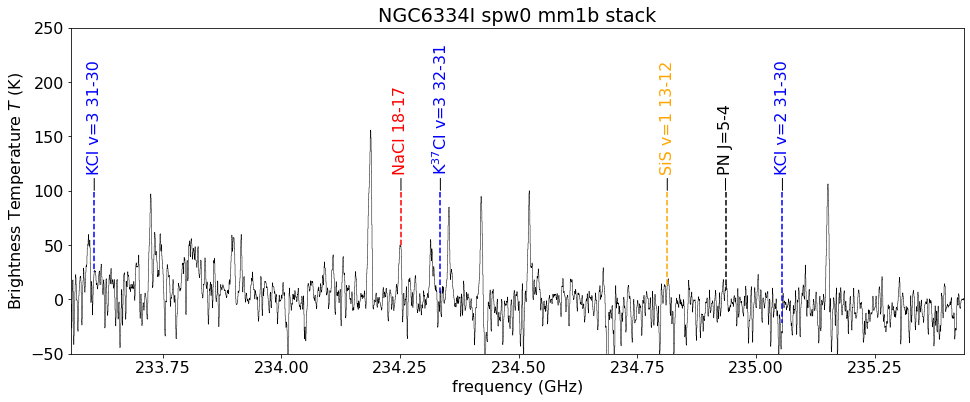

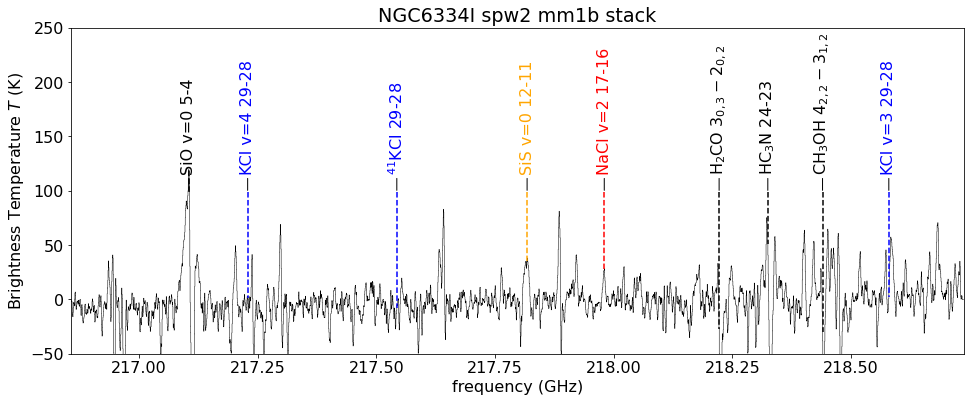

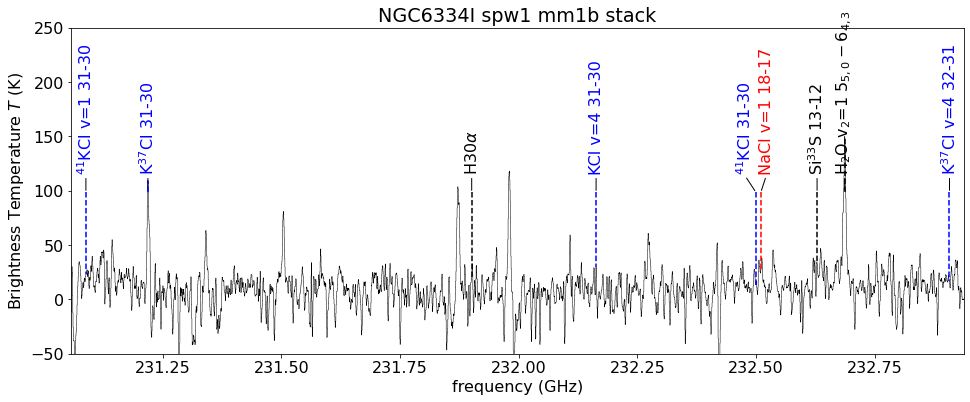

In [131]:
for fn in glob.glob('spectra/figures/color*mm1b_stack.png'):
    display(Image(fn))

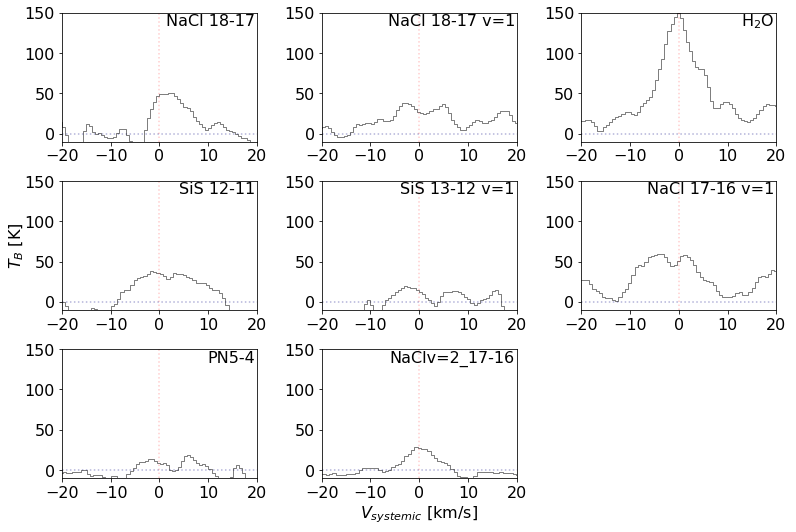

In [132]:
pl.figure(figsize=(12,8))
line_zooms('spectra/*_mm1b_stack.fits', {'NaCl 18-17':  234.251912*u.GHz,
                                         'NaCl 18-17 v=1': 232.509977*u.GHz,
                                         'H$_2$O':  232.6867*u.GHz,
                                         'SiS 12-11':  217.817644*u.GHz,
                                         'SiS 13-12 v=1': 234.8129678*u.GHz,
                                         'NaCl 17-16 v=1': 219.614936*u.GHz,
                                         'PN5-4': 234.935663*u.GHz,
                                         'SiSv=0_13-12': 235.9613634*u.GHz,
                                         'NaClv=2_17-16': 217.979967*u.GHz, # NaCl v=2 17-16
                                         'NaClv=2_18-17':230.7791504*u.GHz, # NaCl v=2 18-17 Unknown_2
                                        }, gridshape=(3,3),
           vcen=0*u.km/u.s,
           dv=20*u.km/u.s,
           ymin=-10,
           ymax=150)

In [133]:
pixscale_au = (np.abs((wcs.utils.proj_plane_pixel_area(stackcmm1b.wcs.celestial)**0.5*u.deg).to(u.arcsec)) * distance).to(u.au, u.dimensionless_angles())
pixscale_au

<Quantity 11.7 AU>

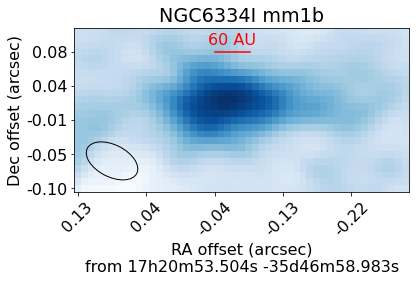

In [134]:
m0 = stackcmm1b.subcube_from_regions(mm1b).moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

dp_60 = (60*u.au / pixscale_au).decompose()

pl.title("NGC6334I mm1b")
pl.plot([20, 20+dp_60], [20,20], color='r')
pl.text(20 + dp_60/2, 21, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(stackcmm1b.wcs.celestial)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xc,yc = 15,11
xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xc-xtlocs)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-yc)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)


ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)
offset_loc = stackcmm1b.wcs.celestial.pixel_to_world(xc,yc)


ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("NGC6334Imm1b_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

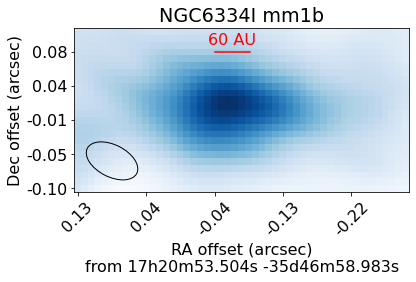

In [135]:
m0 = watermm1cube.moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

dp_60 = (60*u.au / pixscale_au).decompose()

pl.title("NGC6334I mm1b")
pl.plot([20, 20+dp_60], [20,20], color='r')
pl.text(20 + dp_60/2, 21, f'60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xc,yc = 15,11
xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xc-xtlocs)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-yc)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

offset_loc = stackcmm1b.wcs.celestial.pixel_to_world(xc,yc)

ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("NGC6334Imm1b_water_mom0_ticks.png", bbox_inches='tight', dpi=300)

In [136]:
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
from show_pv import show_pv
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv
import pvextractor

Brogan 2018 shows the outflow is nearly straight N/S

In [137]:
pathmm1angle = 270*u.deg
pathmm1 = pvextractor.Path(coordinates.SkyCoord([mm1b[0].center.directional_offset_by(pathmm1angle,0.25*u.arcsec, ),
                                                 mm1b[0].center.directional_offset_by(pathmm1angle+180*u.deg,0.25*u.arcsec, )]))
pvmm1 = pvextractor.extract_pv_slice(stackcmm1b, pathmm1)

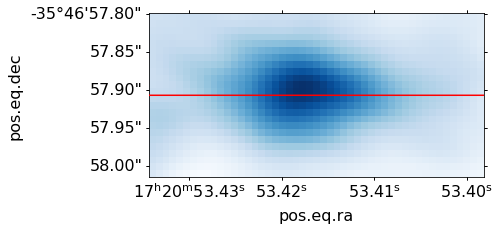

In [138]:
m0 = watermm1cube.moment0()
ax = pl.subplot(projection=m0.wcs)
pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
pathmm1.show_on_axis(ax, spacing=5, color='r')

leftmost: 0.0 arcsec
rightmost: 0.000135 arcsec
endpoints_x = [0.27       0.30846154] arcsec


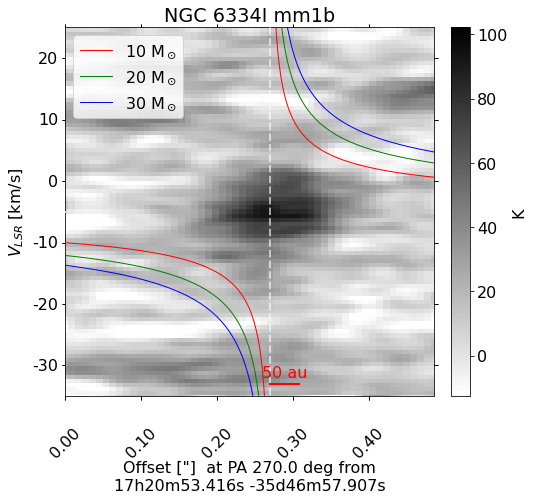

In [139]:
origin = 0.27*u.arcsec
fig,ax,cb,con = show_pv(pvmm1.data, wcs.WCS(pvmm1.header), origin=origin,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(pvmm1.data, 3), imvmax=np.nanmax(pvmm1.data),
                        distance=distance,
                        xoffset_label=origin,
                    )
cb.set_label("K")
kc = show_keplercurves(ax, origin, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')
pl.xlabel(f"Offset [\"]  at PA {pathmm1angle} from\n{mm1b[0].center.to_string('hmsdms', precision=3)}")


pl.title("NGC 6334I mm1b")
pl.savefig("NGC6334Imm1b_naclPV_withcolorcurves.png", bbox_inches='tight')
#pl.legend(loc='best')

leftmost: 1e-05 arcsec
rightmost: 0.0001275 arcsec
endpoints_x = [0.27001    0.30847154] arcsec


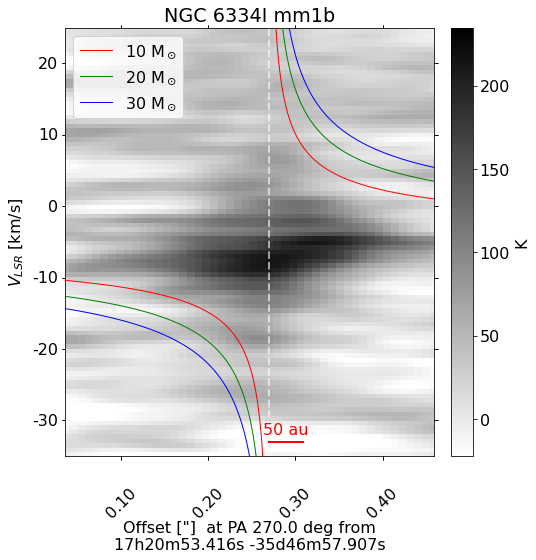

In [140]:
pvmm1water = pvextractor.extract_pv_slice(watermm1cube, pathmm1)
origin = 0.27*u.arcsec

fig,ax,cb,con = show_pv(pvmm1water.data, wcs.WCS(pvmm1water.header), origin=origin,
                vrange=np.array([vcen.value-30, vcen.value+30]), vcen=vcen,
                        imvmin=np.nanpercentile(pvmm1water.data, 3), imvmax=np.nanmax(pvmm1water.data),
                        distance=distance,
                        xoffset_label=origin
                    )
cb.set_label("K")
kc = show_keplercurves(ax, origin, 500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=distance,
                              )
pl.legend(loc='upper left')

pl.xlabel(f"Offset [\"]  at PA {pathmm1angle} from\n{mm1b[0].center.to_string('hmsdms', precision=3)}")


pl.title("NGC 6334I mm1b")
pl.savefig("NGC6334Imm1b_h2oPV_withcolorcurves.png", bbox_inches='tight')
#pl.legend(loc='best')

In [147]:
cube = SpectralCube.read('NGC6334I.config8.spw1.robust0.5.image_small.fits')
regmm1b=mm1b
h2ocubemm1b = watercubemm1b = scubemm1b = (cube.subcube_from_regions(regmm1b)
         .with_spectral_unit(u.GHz)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-15*u.km/u.s+vcen, 15*u.km/u.s+vcen))
# cutout on line above to 'zoom in'
      
# note for no reason   
m3dw = (watercubemm1b.subcube_from_regions(regmm1b) > 30*u.K).include()
m3dw = scipy.ndimage.binary_erosion(m3dw, iterations=2)
m3dw = scipy.ndimage.binary_dilation(m3dw, iterations=3)
#m3dw = m3dw.compute()
m0h2o = watercubemm1b.subcube_from_regions(regmm1b).with_mask(m3dw).moment0(axis=0)
m1h2o = watercubemm1b.subcube_from_regions(regmm1b).with_mask(m3dw).moment1(axis=0)


m3d = (stackc.subcube_from_regions(regmm1b) > 5*u.K).include()
m3d = scipy.ndimage.binary_erosion(m3d, iterations=2)
m3d = scipy.ndimage.binary_dilation(m3d, iterations=3)
#m3d = m3d.compute()

m3d &= m3dw.any(axis=0)

m0 = stackc.subcube_from_regions(regmm1b).with_mask(m3d).moment0()
m1 = stackc.subcube_from_regions(regmm1b).with_mask(m3d).moment1()

      


fig = pl.figure(figsize=(10,7.5))
ax1 = pl.subplot(2,2,1, )#projection=m0.wcs)
im1 = ax1.imshow(m0.value, cmap='Blues', origin='lower')
ax1.set_title("NaCl")
pl.colorbar(mappable=im1)

vmin = vcen.value-15
vmax = vcen.value+15

ax2 = pl.subplot(2,2,2, )#projection=m0h2omm1.wcs)
im2 = ax2.imshow(m0h2o.value, cmap='Blues', origin='lower',)
ax2.set_title("H$_2$O")
cb2 = pl.colorbar(mappable=im2)
cb2.set_label("Integrated Intensity [K km/s]")

ax3 = pl.subplot(2,2,3, )#projection=m1.wcs)
im3 = ax3.imshow(m1.value, cmap='RdBu_r', origin='lower',  vmin=vmin, vmax=vmax)
pl.colorbar(mappable=im3)


ax4 = pl.subplot(2,2,4, )#projection=m1h2omm1.wcs)
im4 = ax4.imshow(m1h2o.value, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
cb4 = pl.colorbar(mappable=im4)
cb4.set_label("$v_{LSR}$ [km/s]")

dp_60 = (60*u.au / pixscale_au).decompose()
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(m0.wcs)**0.5*u.deg).to(u.arcsec))

axlims = ax1.axis()

#xc,yc = 28,29
#offset_loc = m0.wcs.celestial.pixel_to_world(xc,yc)
offset_loc = regmm2b[0].center
xc,yc = m0.wcs.celestial.world_to_pixel(offset_loc)


for ax_ in (ax1,ax2,ax3,ax4):

    xtlocs = ax_.get_xticks()
    xticklabels = map(lambda x: f"{x:0.3f}", (xc-xtlocs)*pixscale.value)
    ax_.set_xticks(xtlocs, xticklabels, rotation=45)
    ax_.axhline(yc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    ax_.axvline(xc, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    ytlocs = ax1.get_yticks()
    yticklabels = map(lambda x: f"{x:0.3f}", (ytlocs-yc)*pixscale.value)
    ax_.set_yticks(ytlocs, yticklabels, rotation=0)

    ax_.axis(axlims)
    
for ax_ in (ax1,ax2):
    ax_.set_xticklabels([])


pl.suptitle("NGC6334I mm1b")
blx = xc
bly = 5
ax1.plot([blx, blx+dp_60], [bly,bly], color='r')
ax1.text(blx + dp_60/2, bly+1, f'60 AU', horizontalalignment='center', color='r')

bm = stackc.beam
bmell = bm.ellipse_to_plot(5, 4, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
ax1.add_artist(bmell)


#ax = fig.add_subplot(111,frameon=False)
#pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#ax.set_xlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}", labelpad=30)
#ax.set_ylabel("Dec offset (arcsec)", labelpad=15)

fig.supxlabel(f"RA offset (arcsec)\nfrom {offset_loc.to_string('hmsdms', precision=3)}",)
fig.supylabel("Dec offset (arcsec)",)


pl.tight_layout()
pl.savefig("NGC6334Imm1b_m0m1_grid_ticks.png", bbox_inches='tight', dpi=300)
#
#contrep,_ = reproject.reproject_interp(cont[0].hdu, m0.header)
#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.contour(contrep,
#                levels=[0.01, 0.02, 0.03, 0.04], colors=['k']*5, linewidths=[0.5]*5)
#pl.savefig("G17_m0m1_grid_ticks_withcont.png", bbox_inches='tight', dpi=300)

UnitConversionError: 'K' (temperature) and 'Jy / beam' are not convertible

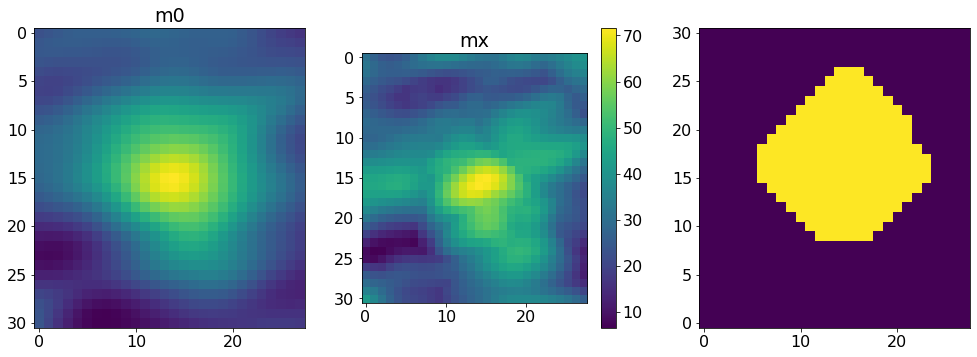

<Figure size 432x288 with 0 Axes>

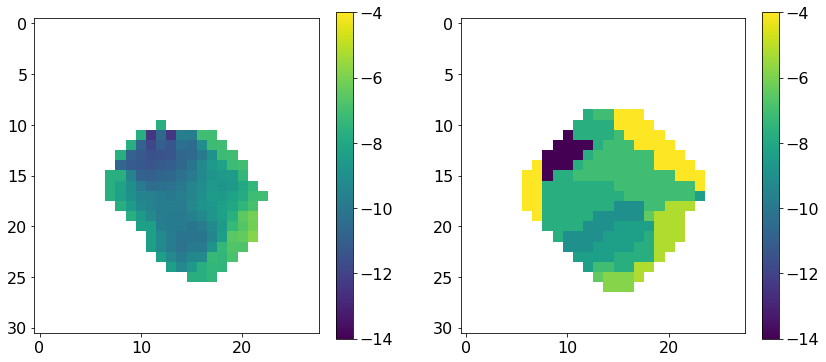

In [71]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubesmm1 if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
vcenmm1d = -9*u.km/u.s
scube = cube.subcube_from_regions(mm1d).to(u.K).with_spectral_unit(u.km/u.s, velocity_convention='radio',
                                                           rest_value=restval).spectral_slab(vcenmm1d-10*u.km/u.s, vcenmm1d+10*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 50*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
from scipy.ndimage import binary_dilation, binary_erosion
m3d = (scube > 40*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
#m3d = m3d.compute()

m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcenmm1d.value-5, vmax=vcenmm1d.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcenmm1d.value-5, vmax=vcenmm1d.value+5)
pl.colorbar()


vmap_mm1d = m1.hdu
#vmap = mxv.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
 n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
 n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562733015.300 Hz:235437322762.241 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
 n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
 n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.783078 deg:  -35.782306 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062732718.000 Hz:232937322464.941 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 310, 277) and unit=K and chunk size (240, 155, 255):
 n_x:    277  type_x: RA---SIN  unit_x: deg    range:   260.222130 deg:  260.222981 deg
 n_y:    310  type_y: DEC--SIN  unit_y: deg    range:   -35.78

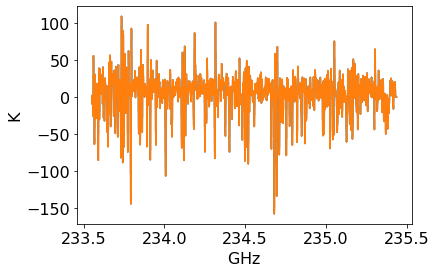

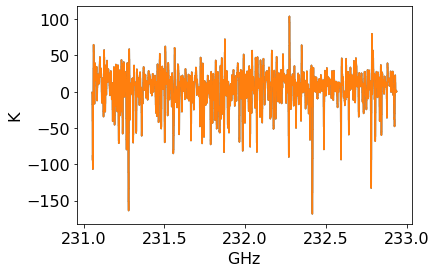

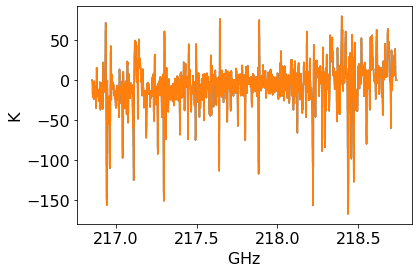

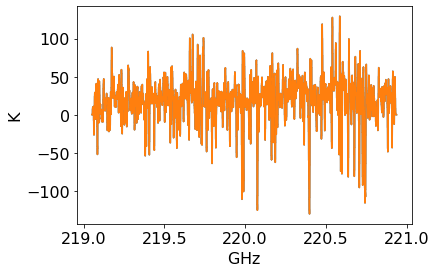

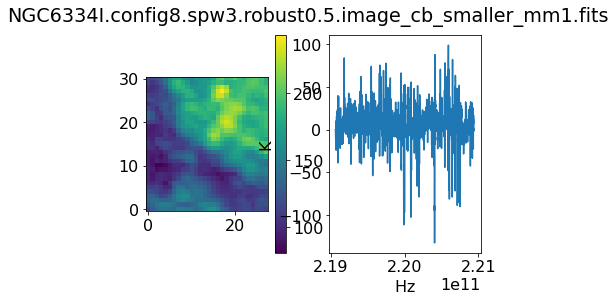

In [72]:
cbflist = (glob.glob('NGC6334I.config8.spw[0-3].robust0.5.image_cb_smaller_mm1.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(mm1d).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_NGC6334Imm1d_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap_mm1d,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap_NGC6334Imm1d.fits', overwrite=True)
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_NGC6334Imm1d_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_NGC6334Imm1d_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_NGC6334Imm1d_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [73]:
stackspectramm1d = []
for ii,fn in enumerate(glob.glob('spectra/*_mm1d_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[2]}_mm1d_stack'
    stackspectramm1d.append(pysp)

NGC6334I_spw0_mm1d_stack
NGC6334I_spw2_mm1d_stack
NGC6334I_spw1_mm1d_stack
NGC6334I_spw3_mm1d_stack


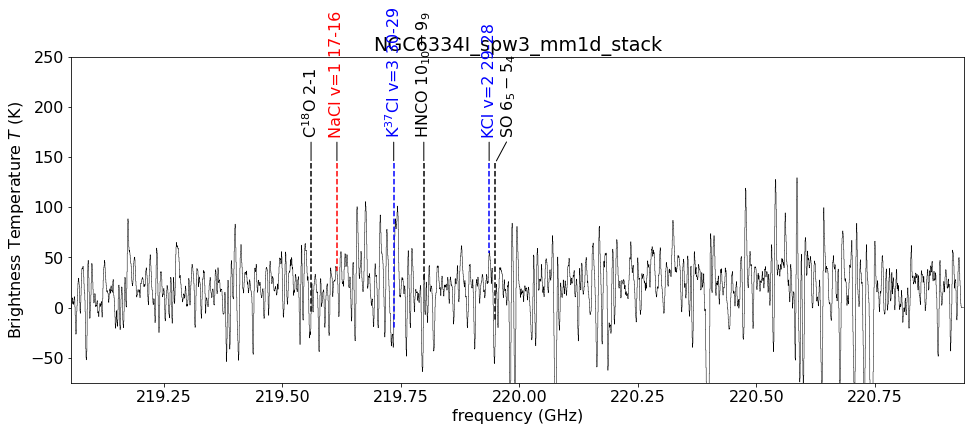

In [74]:
overplot_saltlines(stackspectramm1d, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-75, ymax=250)

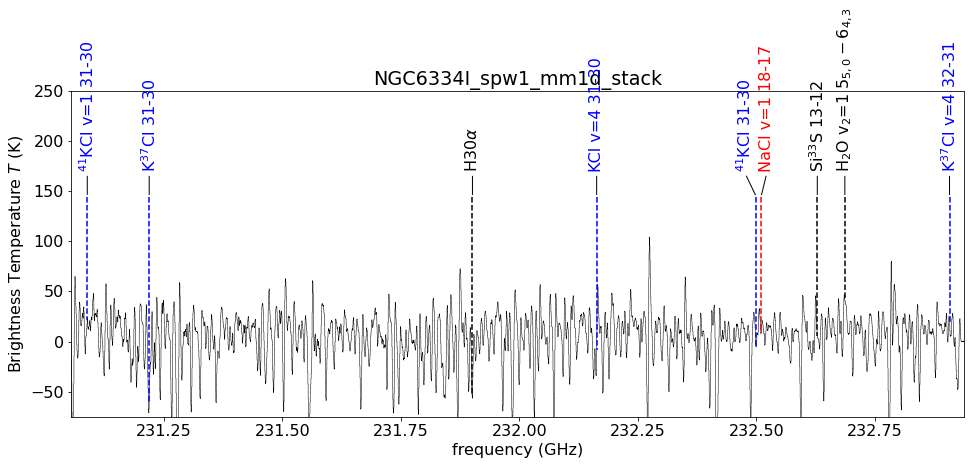

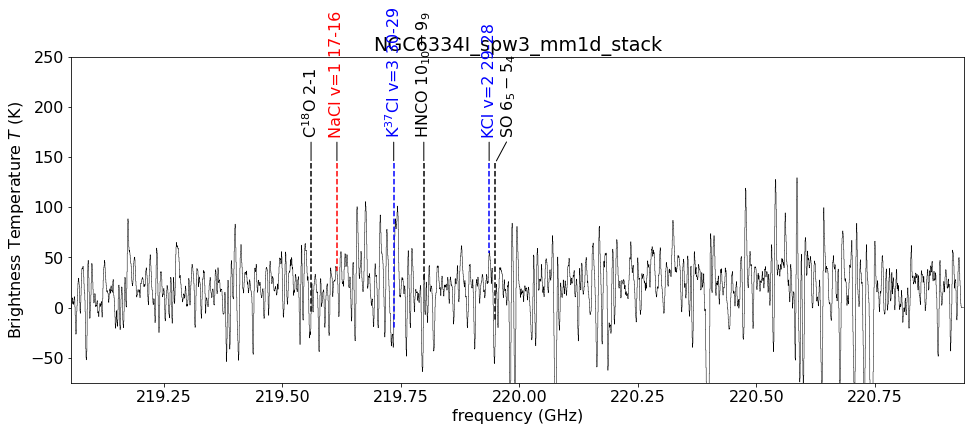

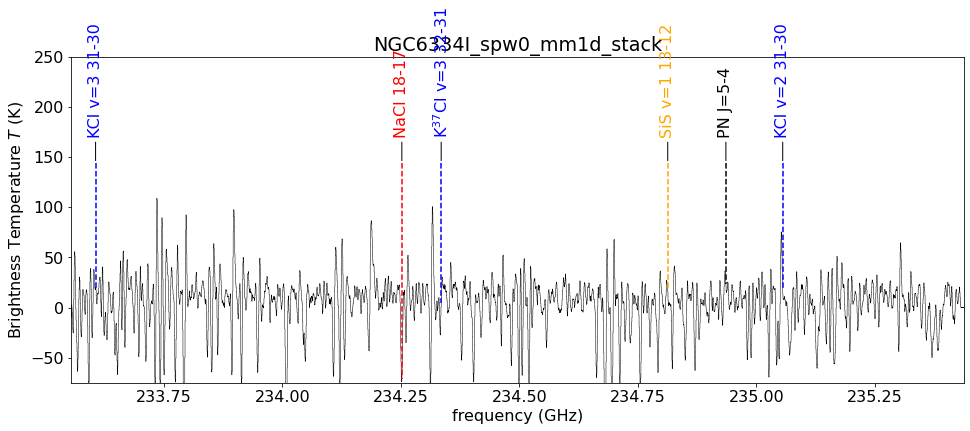

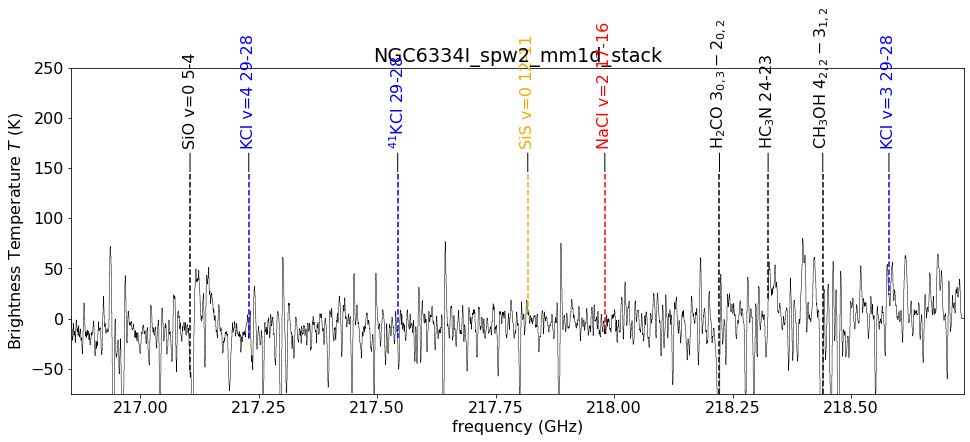

In [75]:
for fn in glob.glob('spectra/figures/color*mm1d_stack.png'):
    display(Image(fn))

# debug code for overplotting salt lines - not associated with 6334I specifically